<a href="https://colab.research.google.com/github/jh5723/SSE_Lab2/blob/main/notebooks/video_pose_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies


This notebook allows users to annotate video frame-by-frame using the ViTPose pose estimation model for several keypoint formats. This is made possible by the easy_ViTPose PyTorch implementation of ViTPose. [Add citations]

First, run the cell below to clone a stable version of the repository. When prompted, restart the session.

In [1]:
!git clone https://github.com/JunkyByte/easy_ViTPose.git
%cd easy_ViTPose
!git fetch --all
!git checkout 9ca694a982c1f6097e8ebf14ae7c12526da89ef0
!git log -1
!pip install -r requirements.txt
!pip install -e .
!pip install ipywidgets
import sys
sys.path.append('/content/easy_ViTPose')

Cloning into 'easy_ViTPose'...
remote: Enumerating objects: 924, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 924 (delta 244), reused 202 (delta 202), pack-reused 665 (from 1)
Receiving objects: 100% (924/924), 8.60 MiB | 39.83 MiB/s, done.
Resolving deltas: 100% (568/568), done.
/content/easy_ViTPose
Fetching origin
Note: switching to '9ca694a982c1f6097e8ebf14ae7c12526da89ef0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 9ca694a fix in

Obtaining file:///content/easy_ViTPose
  Preparing metadata (setup.py) ... done
  Running setup.py develop for easy_ViTPose
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [2]:
import os

from google.colab import drive
drive.mount('/content/my_drive') # force_remount=True if failing

Drive already mounted at /content/my_drive; to attempt to forcibly remount, call drive.mount("/content/my_drive", force_remount=True).


In [3]:
import numpy as np
from io import BytesIO
from PIL import Image
from urllib.request import urlopen
from easy_ViTPose import VitInference
import os
import ipywidgets as widgets
from IPython.display import display
from google.colab.patches import cv2_imshow

Once complete, restart session when prompted. If the prompt does not apepar, restart it manually (Runtime -> Restart session) to make sure installed package versions are updated locally.


Define filters to apply to each frame in a video.

## Test the selected model combination on a still image

Mount Google Drive to access the pre-trained model weights. [Note: provide link to public weights folder here]

In [4]:
#@title Provide a url to an image to perform inference on

# Text box for image URL
image_url = widgets.Text(
    value='https://stf.sg/wp-content/uploads/2020/01/head-kicks-allowed-in-national-championships-01.jpg',
    placeholder='Paste the direct image URL here',
    description='Image URL:',
    style={'description_width': 'initial'}
)

# Button to run inference
button = widgets.Button(description="Confirm selection")

# Display the widgets
display(image_url, button)

Text(value='https://stf.sg/wp-content/uploads/2020/01/head-kicks-allowed-in-national-championships-01.jpg', de…

Button(description='Confirm selection', style=ButtonStyle())

Loading pre-trained pose model weights from: /content/my_drive/My Drive/tkd-ar/model_weights/ViTPose/pre-trained_weights/coco/vitpose-h-coco.pth
Loading pre-trained detector model weights from: /content/my_drive/My Drive/tkd-ar/model_weights/YOLOv8/pre-trained_weights/yolov8x.pt


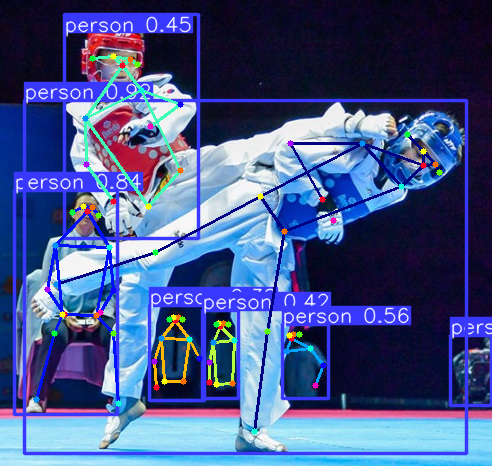

In [12]:
#@title Choose the model and output specifications and run this cell

MODEL_SIZE = 'h'  #@param ['s', 'b', 'l', 'h']
YOLO_SIZE = 'x'  #@param ['n', 's', 'm', 'l', 'x']
DATASET = 'coco'  #@param ['coco_25', 'coco', 'wholebody', 'mpii', 'aic', 'ap10k', 'apt36k']
ext = '.pth'
ext_yolo = '.pt'
url = image_url.value

root_path = '/content/my_drive/My Drive/tkd-ar/model_weights'
pose_path = os.path.join(root_path, 'ViTPose/pre-trained_weights')
pose_path = os.path.join(pose_path, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
detector_path = os.path.join(root_path, 'YOLOv8/pre-trained_weights')
detector_path = os.path.join(detector_path, 'yolov8' + YOLO_SIZE + ext_yolo)
print(f'Loading pre-trained pose model weights from: {pose_path}')
print(f'Loading pre-trained detector model weights from: {detector_path}')

ANNOTATE_VIDEO = 'True'  #@param ['True', 'False']
SHOW_FRAMES = 'True'  #@param ['True', 'False']
OUTPUT_JSON_LABELS = 'True'  #@param ['True', 'False']
SHOW_BBOX = 'True'  #@param ['True', 'False']

model_1 = VitInference(pose_path, detector_path, MODEL_SIZE, dataset=DATASET, yolo_size=320, is_video=False)

img = np.array(Image.open(BytesIO(urlopen(url).read())), dtype=np.uint8)

frame_keypoints = model_1.inference(img)
img = model_1.draw(show_yolo=True)

from google.colab.patches import cv2_imshow
cv2_imshow(img[..., ::-1])

## Helper functions for video inference and dataset preparation

In [5]:
from abc import ABC, abstractmethod
import cv2
import numpy as np
from scipy.signal import convolve2d

class ImageFilter(ABC):
    @abstractmethod
    def apply(self, img: np.ndarray) -> np.ndarray:
        pass

class SharpeningFilter(ImageFilter):
    def apply(self, img: np.ndarray) -> np.ndarray:
        sharpening_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])
        return cv2.filter2D(img, -1, sharpening_kernel)

class WienerFilter(ImageFilter):
    def __init__(self, kernel_size=15, K=10):
        self.kernel_size = kernel_size
        self.K = K

    def apply(self, img: np.ndarray) -> np.ndarray:
        # Define a simple motion blur kernel
        kernel_motion_blur = np.zeros((self.kernel_size, self.kernel_size))
        kernel_motion_blur[int((self.kernel_size - 1) / 2), :] = np.ones(self.kernel_size)
        kernel_motion_blur /= self.kernel_size

        # Apply Wiener Filter for deblurring
        kernel_motion_blur /= np.sum(kernel_motion_blur)
        dummy = np.copy(img)
        dummy = np.fft.fft2(dummy)
        kernel = np.fft.fft2(kernel_motion_blur, s=img.shape)
        kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + self.K)
        dummy = dummy * kernel
        dummy = np.abs(np.fft.ifft2(dummy))
        return np.uint8(dummy)

class UnsharpMaskFilter(ImageFilter):
    def __init__(self, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.amount = amount
        self.threshold = threshold

    def apply(self, img: np.ndarray) -> np.ndarray:
        blurred = cv2.GaussianBlur(img, self.kernel_size, self.sigma)
        sharpened = float(self.amount + 1) * img - float(self.amount) * blurred
        sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
        sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
        sharpened = sharpened.round().astype(np.uint8)
        if self.threshold > 0:
            low_contrast_mask = np.absolute(img - blurred) < self.threshold
            np.copyto(sharpened, img, where=low_contrast_mask)
        return sharpened

def apply_filter(image_path: str, filter: ImageFilter) -> None:
  img = cv2.imread(image_path)
  filtered_img = filter.apply(img)

  cv2.imshow("Original Image", img)
  cv2.imshow("Filtered Image", filtered_img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

In [6]:
import numpy as np
import json
from datetime import datetime

def create_json_output_format(
    keypoints_data, skeleton, width, height, fps, yolo_full_name, vitpose_full_name, dataset, interval_length=3.27
):
    """
    Create a JSON formatted dictionary with keypoints data and video properties, grouped into intervals.

    Args:
        keypoints_data (list): List of dictionaries containing keypoints for each frame.
        skeleton (list): List of skeleton keypoints.
        width (int): Width of the video frame.
        height (int): Height of the video frame.
        fps (float): Frames per second of the video.
        yolo_full_name (str): Full name of the YOLO model used.
        vitpose_full_name (str): Full name of the ViTPose model used.
        dataset (str): Dataset used for pose estimation.
        interval_length (float): Length of each interval in seconds (default is 3.1 seconds).

    Returns:
        dict: JSON formatted dictionary.
    """
    aspect_ratio = width / height  # Calculate aspect ratio

    frames_per_interval_exact = fps * interval_length
    frames_per_interval_floor = int(np.floor(frames_per_interval_exact))
    remainder = frames_per_interval_exact - frames_per_interval_floor
    remainder_accumulated = 0

    # Skip the first two frames as warm-up
    keypoints_data = keypoints_data[2:]

    # Group frames into intervals
    techniques = {}
    technique_idx = 0

    start_idx = 0
    while start_idx < len(keypoints_data):
        interval_frames_count = frames_per_interval_floor
        remainder_accumulated += remainder
        if remainder_accumulated >= 1:
            interval_frames_count += 1
            remainder_accumulated -= 1

        end_idx = min(start_idx + interval_frames_count, len(keypoints_data))
        interval_frames = keypoints_data[start_idx:end_idx]

        techniques[technique_idx] = {
            'frames': []
        }

        for frame_data in interval_frames:
            persons = []

            for person_id, keypoints_info in frame_data['keypoints'].items():
                keypoints_array = np.array(keypoints_info)
                num_keypoints = len(skeleton)

                # Check if the keypoints are already in the correct shape
                if keypoints_array.size != num_keypoints * 3:
                    print(f"Warning: Unexpected keypoints size for person {person_id} in frame {frame_data['frame']}")
                    continue

                keypoints_array = keypoints_array.reshape(num_keypoints, 3)
                keypoints_list = keypoints_array.tolist()

                persons.append({
                    'person_id': person_id,
                    'keypoints': keypoints_list
                })

            techniques[technique_idx]['frames'].append({
                'frame_number': frame_data['frame'],
                'persons': persons
            })

        # Check if the last technique needs padding
        if len(interval_frames) < interval_frames_count:
            last_frame = techniques[technique_idx]['frames'][-1]
            for _ in range(interval_frames_count - len(interval_frames)):
                techniques[technique_idx]['frames'].append(last_frame)

        technique_idx += 1
        start_idx = end_idx

    return {
        'techniques': techniques,
        'detection_model': yolo_full_name,
        'pose_model': vitpose_full_name,
        'pose_format': dataset,
        'skeleton': skeleton,
        'camera_properties': {
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'fps': fps
        },
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

In [7]:
import numpy as np
import cv2
import json
import tqdm
import time
from datetime import datetime
from google.colab.patches import cv2_imshow
from easy_ViTPose.vit_utils.inference import NumpyEncoder, VideoReader
from easy_ViTPose.inference import VitInference
from easy_ViTPose.vit_utils.visualization import joints_dict

def setup_video_reader(video_path):
    reader = VideoReader(video_path)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    return reader, width, height, total_frames, fps

def initialize_video_writer(output_video_path, width, height, fps):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    return out

def process_frames(reader, total_frames, model, num_keypoints, filter: ImageFilter = None):
    keypoints_data = []

    for ith, img in tqdm.tqdm(enumerate(reader), total=total_frames):
        t0 = time.time()

        if img is None:
            print(f"Frame {ith} is None, skipping.")
            continue

        if filter:
            img = filter.apply(img)

        frame_keypoints = model.inference(img)

        if not frame_keypoints:
            detected_keypoints = {
                "NaN": np.full((num_keypoints, 3), np.nan).flatten()
            }
        else:
            detected_keypoints = {}
            for person_id, keypoints in frame_keypoints.items():
                keypoints_array = np.array(keypoints).reshape(-1, 3)
                detected_keypoints[person_id] = np.nan_to_num(keypoints_array.flatten(), nan=np.nan)

        keypoints_data.append({
            'frame': ith,
            'keypoints': detected_keypoints,
            'processing_time': time.time() - t0
        })

    return keypoints_data


def process_video_showing_output(reader, total_frames, model, num_keypoints, output_video_path, fps=30, frame_size=(640, 480)):
    keypoints_data = []

    out = initialize_video_writer(output_video_path, frame_size[0], frame_size[1], fps)

    for ith, img in tqdm.tqdm(enumerate(reader), total=total_frames):
        t0 = time.time()

        if img is None:
            print(f"Frame {ith} is None, skipping.")
            continue

        # Perform inference to get keypoints
        frame_keypoints = model.inference(img)

        img_with_keypoints = model.draw(show_yolo=True)[..., ::-1]  # Convert to BGR for OpenCV
        out.write(img_with_keypoints)

        if not frame_keypoints:
            # Handle missing keypoints by labeling them as empty
            detected_keypoints = {
                # No person detected, use NaN for the person_id
                "NaN": np.full((num_keypoints, 3), np.nan).flatten()
            }
        else:
            detected_keypoints = {}
            for person_id, keypoints in frame_keypoints.items():
                keypoints_array = np.array(keypoints).reshape(-1, 3)

                # Directly use detected keypoints, label missing keypoints as NaN
                detected_keypoints[person_id] = np.nan_to_num(keypoints_array.flatten(), nan=np.nan)

        keypoints_data.append({
            'frame': ith,
            'keypoints': detected_keypoints,
            'processing_time': time.time() - t0
        })

    out.release()
    return keypoints_data

def save_json_output(output_json_path, keypoints_data, model, width, height, fps, yolo_size, model_size, dataset):

    skeleton = joints_dict()[model.dataset]['keypoints']
    yolo_size_mapping = {
        's': 'yolov8s',
        'n': 'yolov8n',
        'm': 'yolov8m',
        'l': 'yolov8l',
        'x': 'yolov8x'
    }
    vitpose_size_mapping = {
        's': 'vitpose-s',
        'b': 'vitpose-b',
        'l': 'vitpose-l',
        'h': 'vitpose-h'
    }
    yolo_full_name = yolo_size_mapping.get(yolo_size, 'unknown_yolo_size')
    vitpose_full_name = f"{vitpose_size_mapping.get(model_size, 'unknown_vitpose_size')}-{dataset}"

    output_data = create_json_output_format(keypoints_data, skeleton, width, height, fps, yolo_full_name, vitpose_full_name, dataset)

    with open(output_json_path, 'w') as f:
        json.dump(output_data, f, cls=NumpyEncoder)

def display_first_frame(output_video_path):

    cap = cv2.VideoCapture(output_video_path)
    ret, frame = cap.read()
    if ret:
        cv2_imshow(frame)
    cap.release()

def output_statistics(keypoints_data, fps_list, tot_time):

    tot_poses = sum(len(k['keypoints']) for k in keypoints_data)
    print(f'Mean inference FPS: {1 / np.mean(fps_list):.2f}')
    print(f'Total poses predicted: {tot_poses}, mean per frame: {(tot_poses / len(keypoints_data)):.2f}')
    print(f'Mean FPS per pose: {(tot_poses / tot_time):.2f}')

def process_video(model, keypoints, video_path, output_json_path, output_video_path='output_video.mp4', prepare_output_video=False, show_frames=False, yolo_size='s', model_size='b', dataset='coco', interpolate_threshold=3, filter: ImageFilter = None):
    reader, width, height, total_frames, fps = setup_video_reader(video_path)

    if prepare_output_video:
        keypoints_data = process_video_showing_output(reader, total_frames, model, keypoints, output_video_path, fps=fps, frame_size=(width, height))
    else:
        keypoints_data = process_frames(reader, total_frames, model, keypoints, filter=filter)

    save_json_output(output_json_path, keypoints_data, model, width, height, fps, yolo_size, model_size, dataset)

    if show_frames:
        display_first_frame(output_video_path)

    fps_list = [frame['processing_time'] for frame in keypoints_data]
    tot_time = sum(fps_list)
    output_statistics(keypoints_data, fps_list, tot_time)


In [8]:
def get_keypoint_no(skel_format):
  if skel_format == 'coco':
    return 17
  elif skel_format == 'coco_25':
    return 25
  elif skel_format == 'mpii':
    return 16
  elif skel_format == 'aic':
    return 14
  elif skel_format == 'apt36k':
    print("Warning: This pose format is for labelling animals.")
    return 36
  elif skel_format == 'ap10k':
    print("Warning: This pose format is for labelling animals.")
    return 10 # Animal pose estimation
  elif skel_format == 'wholebody':
    print("Warning: Labels 132 keypoints, most of which are in the face and hands.")
    return 132 # Whole body COCO pose estimation, with many face and hand keyoints
  else:
    raise ValueError(f"Unsupported skeleton format: {skel_format}")

## Run inference on a video

In [ ]:
#@title Select the model, filter and output configurations

from easy_ViTPose import VitInference


MODEL_SIZE = 'l'  #@param ['s', 'b', 'l', 'h']
YOLO_SIZE = 'm'  #@param ['n', 's', 'm', 'l', 'x']
DATASET = 'coco_25'  #@param ['coco_25', 'coco', 'wholebody', 'mpii', 'aic', 'ap10k', 'apt36k']
ext = '.pth'
ext_yolo = '.pt'

root_path = '/content/my_drive/My Drive/tkd-ar/model_weights'
pose_path = os.path.join(root_path, 'ViTPose/pre-trained_weights')
pose_path = os.path.join(pose_path, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
detector_path = os.path.join(root_path, 'YOLOv8/pre-trained_weights')
detector_path = os.path.join(detector_path, 'yolov8' + YOLO_SIZE + ext_yolo)
print(f'Loading pre-trained pose model weights from: {pose_path}')
print(f'Loading pre-trained detector model weights from: {detector_path}')

ANNOTATE_VIDEO = 'True'  #@param ['True', 'False']
SHOW_FRAMES = 'True'  #@param ['True', 'False']
OUTPUT_JSON_LABELS = 'True'  #@param ['True', 'False']
SHOW_BBOX = 'True'  #@param ['True', 'False']

prepare_output_video = ANNOTATE_VIDEO == 'True'
show_frames = SHOW_FRAMES == 'True'
output_json_labels = OUTPUT_JSON_LABELS == 'True'
show_bbox = SHOW_BBOX == 'True'

filter = 'unsharp_mask'  #@param ['none', 'sharpening', 'wiener', 'unsharp_mask']

keypoints = get_keypoint_no(DATASET)

root_path = '/content/my_drive/MyDrive/tkd-ar/video_data/source_files'
input_path = os.path.join(root_path, 'test_clip.MP4')
json_path = os.path.join(root_path, f'test_clip_v{MODEL_SIZE}_y{YOLO_SIZE}_f{filter}.json')
output_path = os.path.join(root_path, f'test_clip_v{MODEL_SIZE}_y{YOLO_SIZE}_f{filter}.MP4')

model_2 = VitInference(pose_path, detector_path, MODEL_SIZE,
                     dataset=DATASET, yolo_size=320, is_video=True)

process_video(model_2, keypoints, input_path, json_path, output_path, prepare_output_video=prepare_output_video, show_frames=show_frames, yolo_size=YOLO_SIZE, model_size=MODEL_SIZE, dataset=DATASET, filter=filter)


Loading pre-trained pose model weights from: /content/my_drive/My Drive/tkd-ar/model_weights/ViTPose/pre-trained_weights/coco_25/vitpose-l-coco_25.pth
Loading pre-trained detector model weights from: /content/my_drive/My Drive/tkd-ar/model_weights/YOLOv8/pre-trained_weights/yolov8m.pt


 55%|█████▌    | 495/895 [01:11<00:53,  7.53it/s]